In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

from astroML.utils import completeness_contamination

import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
file = '../solutions/galaxyquasar.csv'
data= np.genfromtxt(file, delimiter=',', dtype = str)
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [3]:
#colors
ug = data[1:,0].astype(float) - data[1:,1].astype(float)
gr = data[1:,1].astype(float) - data[1:,2].astype(float)
ri = data[1:,2].astype(float) - data[1:,3].astype(float)
iz = data[1:,3].astype(float) - data[1:,4].astype(float)

galaxies = data[1:,0:4][data[1:,5]=='GALAXY'].astype(float)
quasars = data[1:,0:4][data[1:,5]=='QSO'].astype(float)

labels = np.char.replace(data[1:,5], 'GALAXY', '0')
labels = np.char.replace(labels, 'QSO', '1').astype(float)

In [4]:
ug_train, ug_test, gr_train, gr_test, ri_train, ri_test, iz_train, iz_test, labels_train, labels_test = train_test_split(ug, gr, ri, iz, labels, test_size=0.3)


In [5]:
colors_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))
colors_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))
labels_corner = [r'$u-g$', r'$g-r$', r'$r-i$', r'$i-z$']

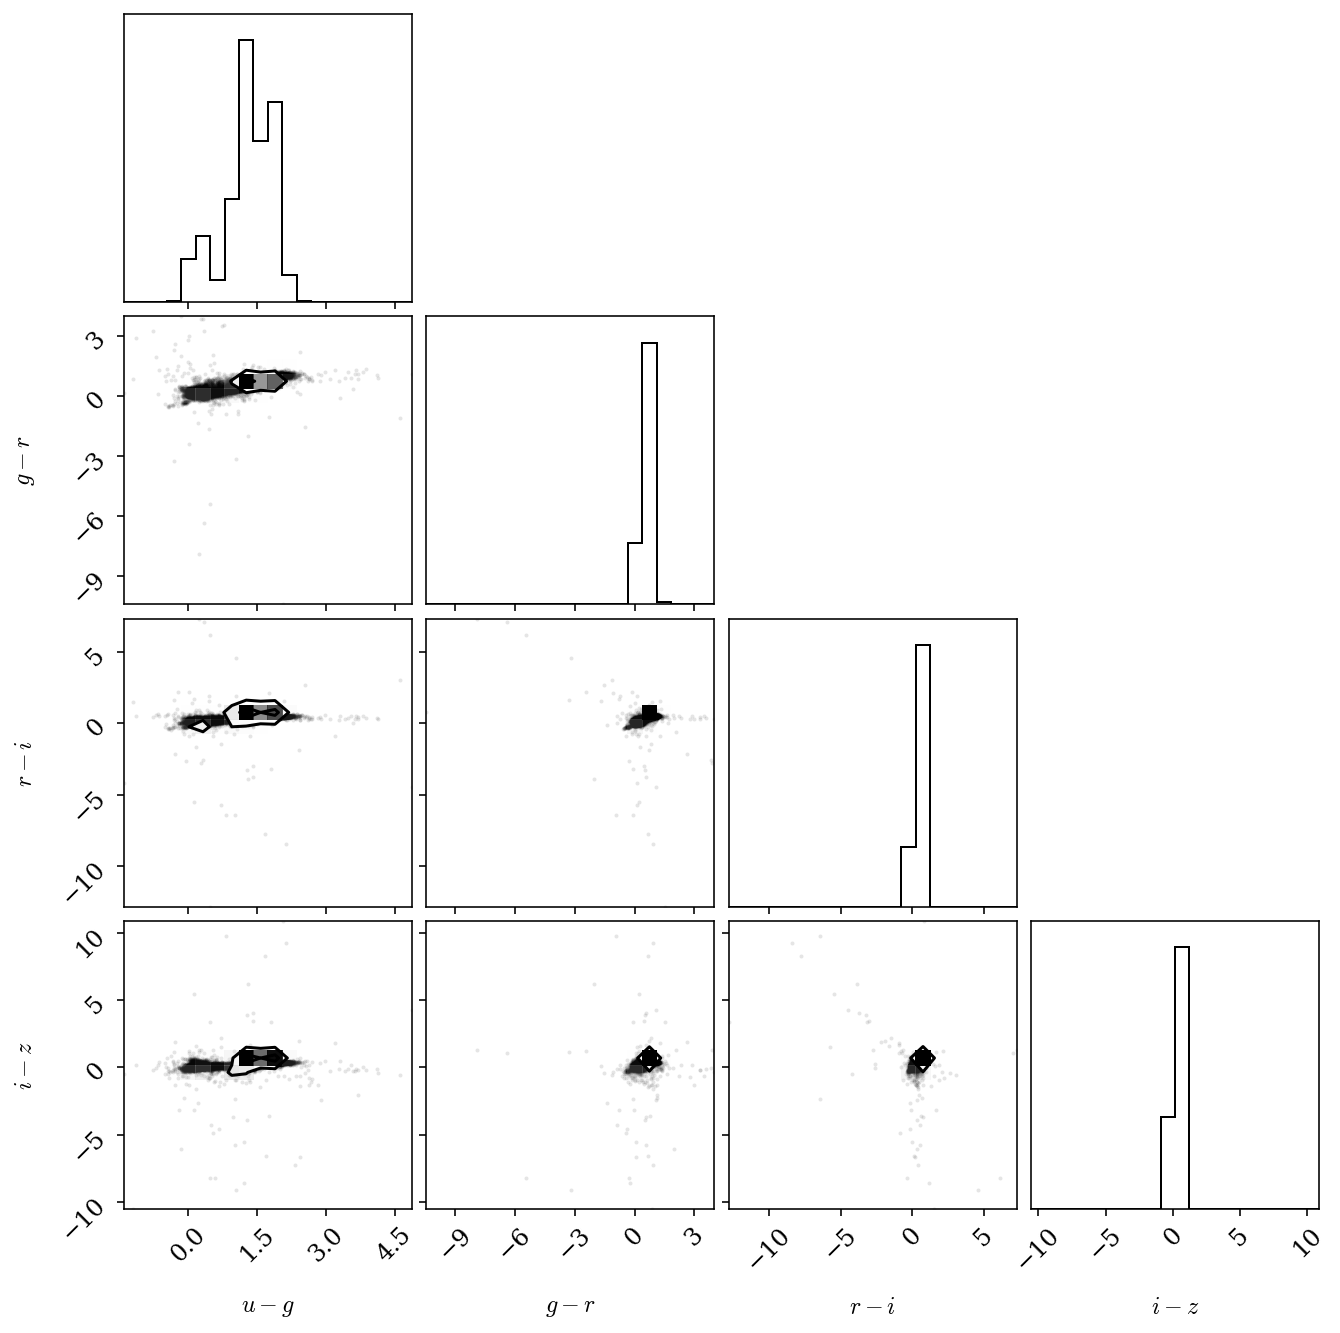

In [6]:
corner.corner(colors_train, labels = labels_corner);

$u-g$ is the most promising color 

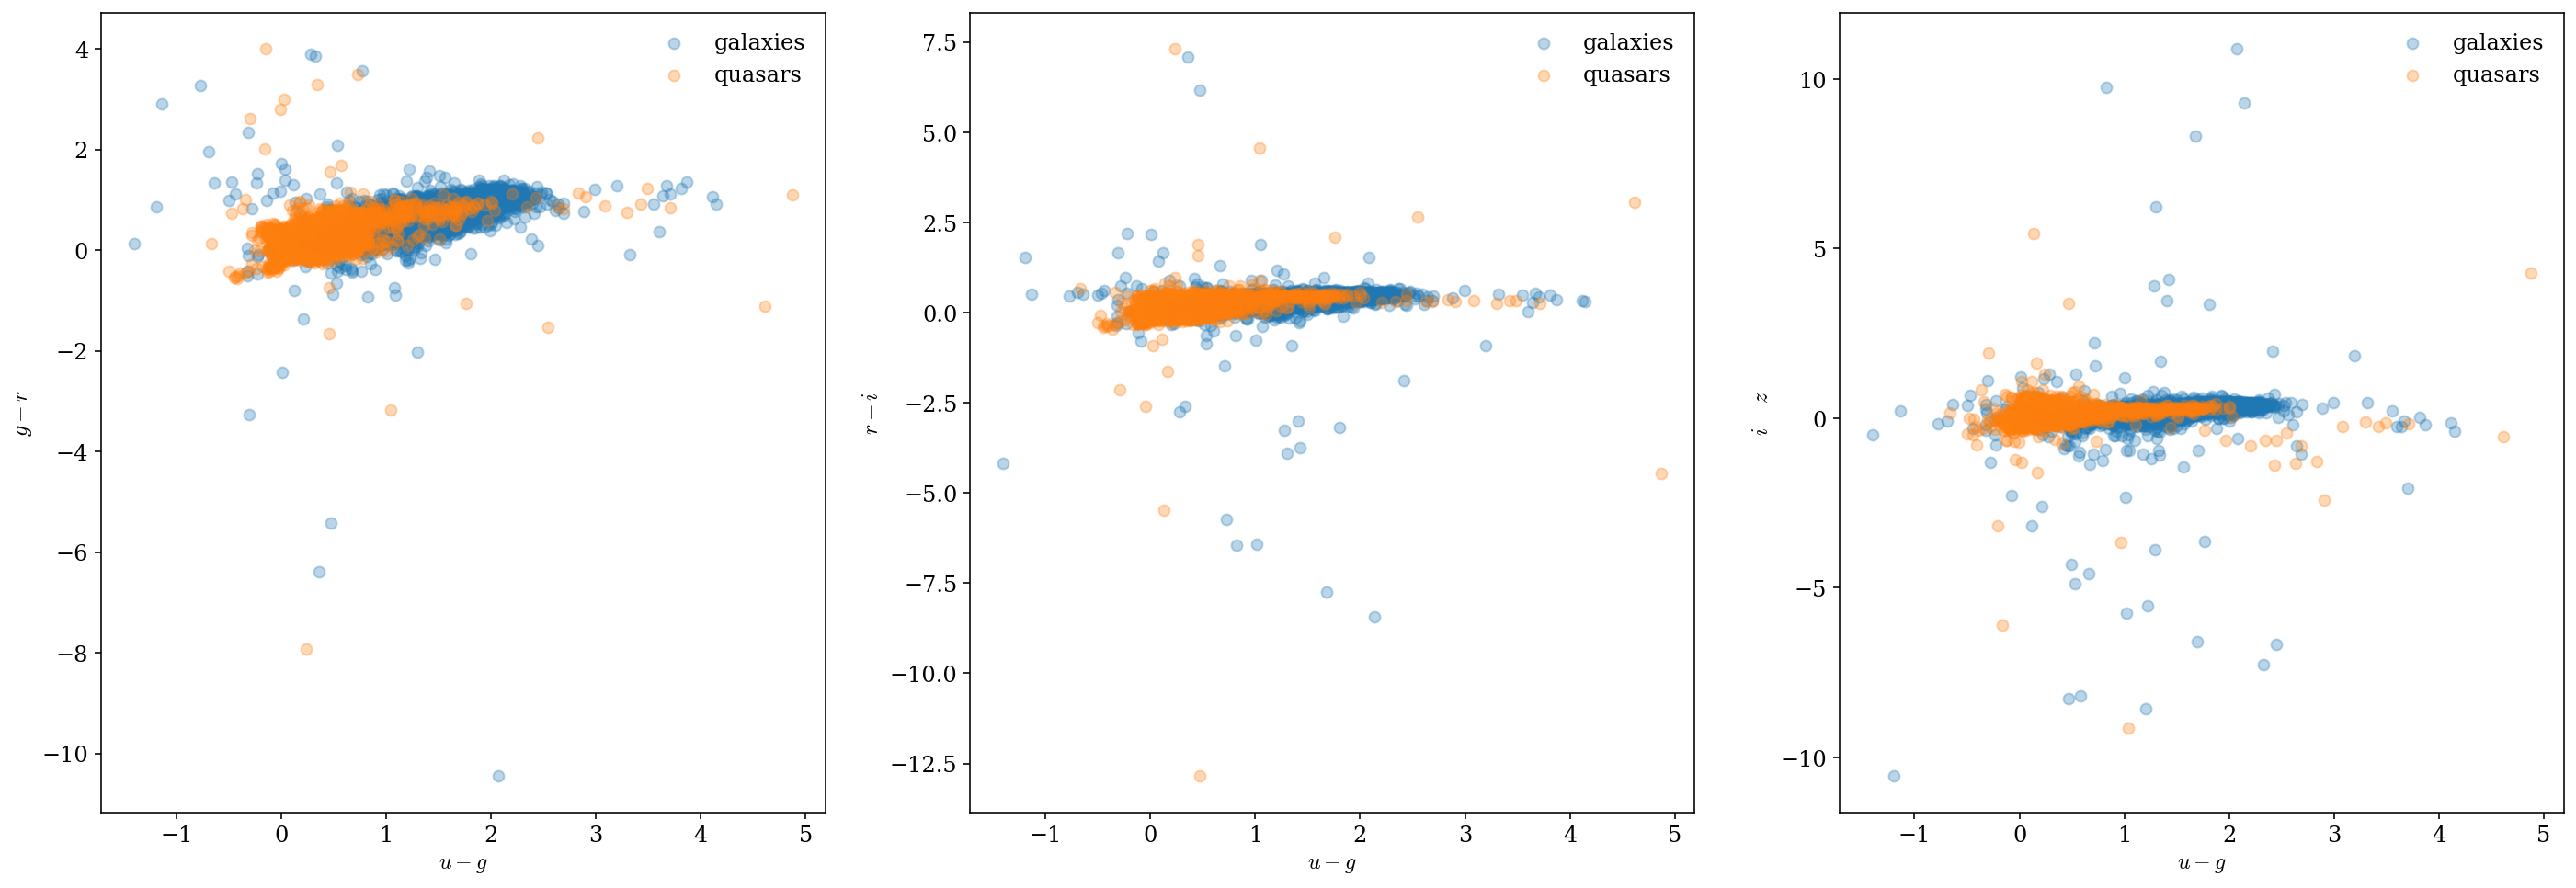

In [7]:
fig, axs = plt.subplots(1,3, figsize = (24,8))

axs[0].scatter(ug_train[labels_train == 0], gr_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[0].scatter(ug_train[labels_train == 1], gr_train[labels_train == 1], alpha=0.3, label='quasars')
axs[0].set_xlabel(r'$u-g$') 
axs[0].set_ylabel(r'$g-r$')
axs[0].legend(frameon = False)

axs[1].scatter(ug_train[labels_train == 0], ri_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[1].scatter(ug_train[labels_train == 1], ri_train[labels_train == 1], alpha=0.3, label='quasars')
axs[1].set_xlabel(r'$u-g$') 
axs[1].set_ylabel(r'$r-i$')
axs[1].legend(frameon = False)

axs[2].scatter(ug_train[labels_train == 0], iz_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[2].scatter(ug_train[labels_train == 1], iz_train[labels_train == 1], alpha=0.3, label='quasars')
axs[2].set_xlabel(r'$u-g$') 
axs[2].set_ylabel(r'$i-z$')
axs[2].legend(frameon = False)

plt.show()

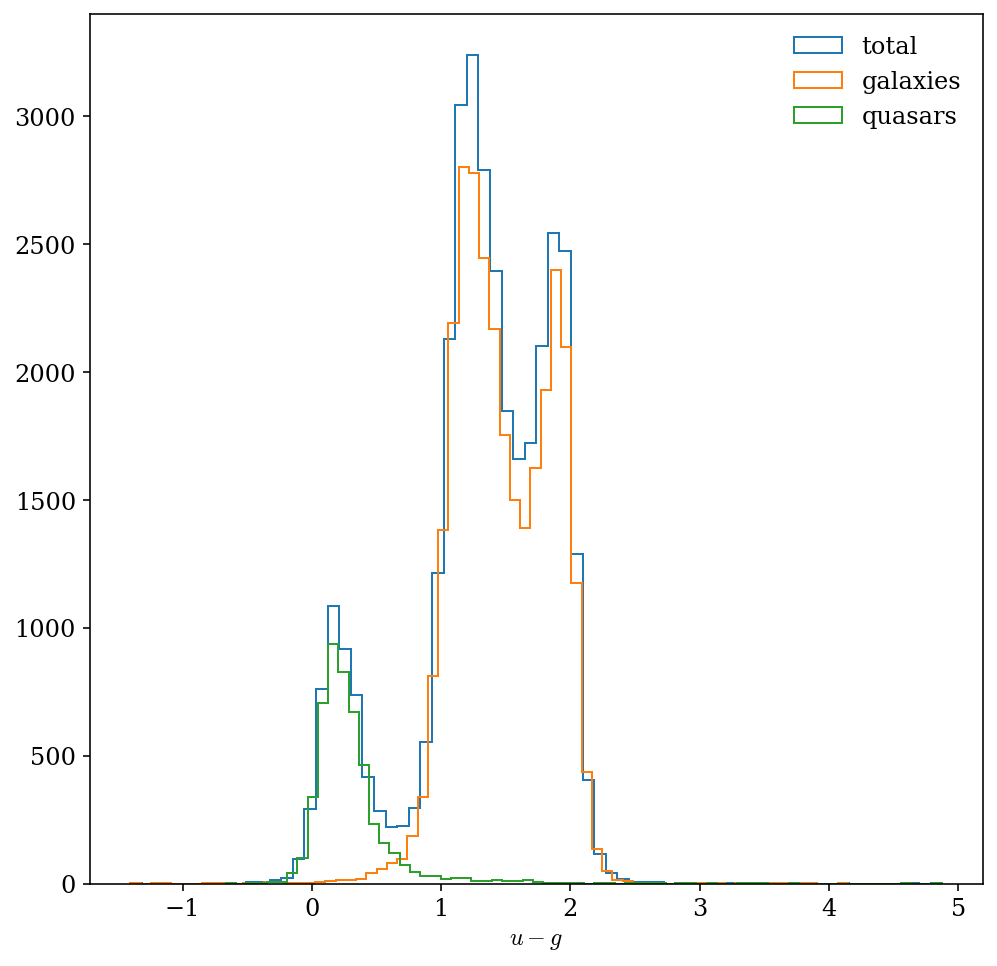

In [8]:
plt.hist(ug_train, bins = 70, histtype = 'step', label='total')
plt.hist(ug_train[labels_train == 0], bins = 70, histtype = 'step', label='galaxies')
plt.hist(ug_train[labels_train == 1], bins = 70, histtype = 'step', label='quasars')

plt.xlabel(r'$u-g$')
plt.legend(frameon = False)
plt.show()

## Classification

In [9]:
# using u-g and g-r
X_train = colors_train[:,0:2]
X_test = colors_test[:,0:2]

### Gaussian naive bayes

In [10]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]

    clf = GaussianNB()
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [11]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [12]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [13]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.91955617 0.92001849 0.91770689 0.91724457]
contamination:  [0.05779252 0.11001789 0.10946613 0.11978705]


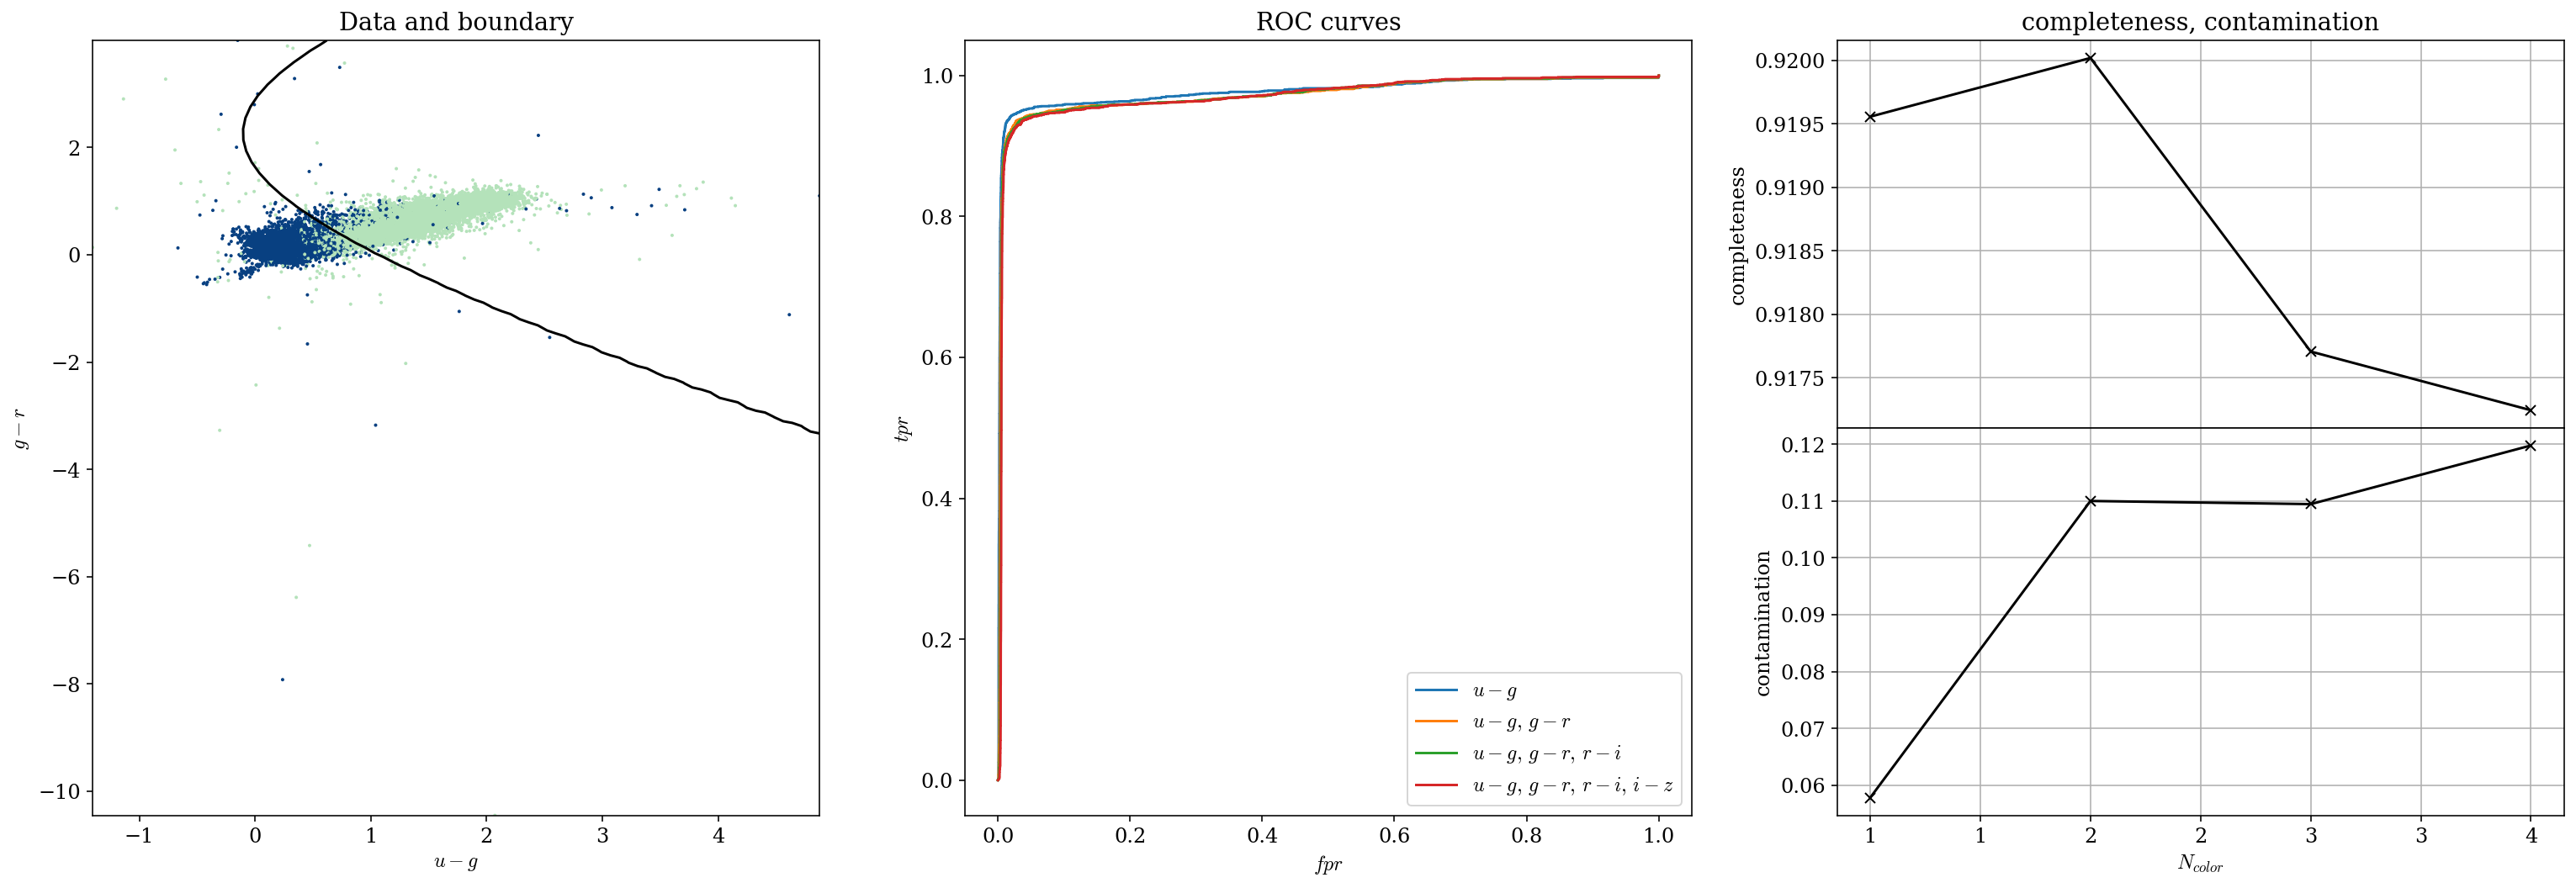

In [14]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

**$u-g$ is the most important feature** (as expected from the corner plot, it's the only color with a relevant variability)

### K-Nearest Neighbor